<a href="https://colab.research.google.com/github/Se00n00/Physician-Notetaker/blob/main/Notebooks/Sentiment_%26_Intent_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers torch sentencepiece kagglehub[pandas-datasets]

```
@dataset{
      title={Sentiment Analysis for Mental Health},
      author={Suchintika Sarkar},
      source={kaggle.com}
      dataset_classess=[
          Normal,
          Depression,
          Suicidal,
          Anxiety,
          Stress,
          Bi-Polar,
          Personality Disorder
      ]
      url={https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health},
}
```

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "Combined Data.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "suchintikasarkar/sentiment-analysis-for-mental-health",
  file_path,
)

print("First 5 records:", df.head())

/tmp/ipython-input-2294779335.py:6: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'sentiment-analysis-for-mental-health' dataset.
First 5 records:    Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


In [ ]:
df

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [ ]:
df.isna().sum()

,0
Unnamed: 0,0
statement,362
status,0


In [ ]:
df.dropna(inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)
df = df.sample(n=6000, random_state=42).reset_index(drop=True)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['status'])
X_train, X_test, y_train, y_test = train_test_split(df['statement'], df['label'], test_size=0.2, random_state=42)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [ ]:
tokenizer =  BertTokenizer.from_pretrained('bert-base-uncased')

X_train_tokenize = tokenizer(list(X_train), padding=True, truncation=True, max_length=200)
X_test_tokenize = tokenizer(list(X_test), padding=True, truncation=True, max_length=200)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from datasets import Dataset

In [ ]:
train_dataset = Dataset.from_dict({
    'input_ids': X_train_tokenize['input_ids'],
    'attention_mask': X_train_tokenize['attention_mask'],
    'labels': list(y_train)
})

test_dataset = Dataset.from_dict({
    'input_ids': X_test_tokenize['input_ids'],
    'attention_mask': X_test_tokenize['attention_mask'],
    'labels': list(y_test)
})

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = len(le.classes_))
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    lr_scheduler_type="linear",
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=3,
    gradient_accumulation_steps=2
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(
    model = model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [ ]:
import wandb
wandb.init(project="Medical Sentiment Analysis", mode="offline")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.468500,1.404390
2,0.797600,0.786876
3,0.576500,0.632774
4,0.401600,0.557794
5,0.323300,0.564362


TrainOutput(global_step=750, training_loss=0.8734572849273682, metrics={'train_runtime': 914.5486, 'train_samples_per_second': 26.242, 'train_steps_per_second': 0.82, 'total_flos': 2466776880000000.0, 'train_loss': 0.8734572849273682, 'epoch': 5.0})

                      precision    recall  f1-score   support

             Anxiety       0.82      0.84      0.83        83
             Bipolar       0.59      0.75      0.66        56
          Depression       0.79      0.66      0.72       369
              Normal       0.95      0.96      0.95       379
Personality disorder       0.45      0.21      0.29        24
              Stress       0.55      0.58      0.57        55
            Suicidal       0.63      0.76      0.69       234

            accuracy                           0.78      1200
           macro avg       0.68      0.68      0.67      1200
        weighted avg       0.78      0.78      0.78      1200



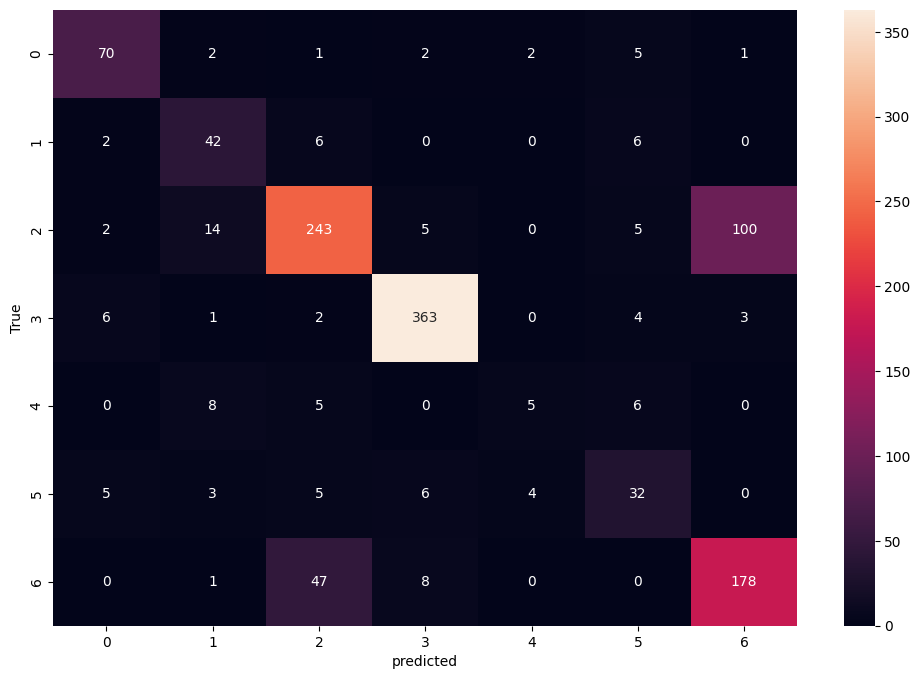

In [ ]:
pred, labels, _ = trainer.predict(test_dataset)

predicted_labels = np.argmax(pred, axis=1)

print(classification_report(y_test, predicted_labels, target_names=le.classes_))

cm = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import torch
import numpy as np

In [ ]:
def analyze_intent(dialoge:str)->str:
  text = tokenizer([dialoge], padding=True, truncation=True, max_length=200)
  input_ids = torch.tensor(text['input_ids'])
  attention_mask = torch.tensor(text['attention_mask'])
  with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    predicted_label = torch.argmax(outputs.logits, dim=1).item()
    return predicted_label

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained("mindpadi/intent_classifier")
tokenizer = AutoTokenizer.from_pretrained("mindpadi/intent_classifier")

text = "I’m struggling with my emotions today"
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)

predicted_class = torch.argmax(outputs.logits, dim=1).item()
print("Predicted intent ID:", predicted_class)